In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
import shap
import matplotlib.pyplot as plt

# 1. 데이터 로드 및 전처리
file_path = "/content/drive/MyDrive/Colab Notebooks/combined_dataset.xlsx"
df = pd.read_excel(file_path)

X_raw = df[[str(i) for i in range(1, 2101)]].dropna()
y_sbp = df.loc[X_raw.index, 'Systolic Blood Pressure(mmHg)']
y_dbp = df.loc[X_raw.index, 'Diastolic Blood Pressure(mmHg)']

def sliding_window_transform(X_raw, y_sbp, y_dbp, window_size, stride):
    X_win, y_win = [], []
    for i in range(len(X_raw)):
        row = X_raw.iloc[i].values
        for start in range(0, 2100 - window_size + 1, stride):
            end = start + window_size
            X_win.append(row[start:end])
            y_win.append([y_sbp.iloc[i], y_dbp.iloc[i]])
    return np.array(X_win), np.array(y_win)

window_size = 200
stride = 200
X_win, y_win = sliding_window_transform(X_raw, y_sbp, y_dbp, window_size, stride)

# 1차 및 2차 미분 특징 추가
first_deriv = np.gradient(X_win, axis=1)
second_deriv = np.gradient(first_deriv, axis=1)
X_combined = np.concatenate([X_win, first_deriv, second_deriv], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined.reshape(-1, X_combined.shape[1])).reshape(X_combined.shape)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y_win, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

# 2. 모델 정의
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(channels),
            nn.ELU()
        )

    def forward(self, x):
        return x + self.conv(x)

class ECALayer(nn.Module):
    def __init__(self, channels, k_size=3):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size-1)//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x).transpose(-1, -2)
        y = self.conv(y).transpose(-1, -2)
        return x * self.sigmoid(y)

class ShallowPPGEncoder(nn.Module):
    def __init__(self, in_channels=1, cnn_channels=64, kernel_size=15):
        super().__init__()
        self.temporal_conv = nn.Sequential(
            nn.Conv1d(in_channels, cnn_channels, kernel_size, padding=kernel_size//2),
            nn.BatchNorm1d(cnn_channels),
            nn.ELU(),
            nn.MaxPool1d(2),
            ResidualBlock(cnn_channels),
            ECALayer(cnn_channels)
        )

    def forward(self, x):
        x = self.temporal_conv(x)
        x = x.permute(0, 2, 1)
        return x

class FineTemporalBranch(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(d_model, d_model, kernel_size=5, padding=2),
            nn.BatchNorm1d(d_model),
            nn.ELU(),
            nn.MaxPool1d(2),
            ResidualBlock(d_model)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = x.permute(0, 2, 1)
        return x

class CoarseTransformerBranch(nn.Module):
    def __init__(self, d_model, nhead):
        super().__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=0.1, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=3)

    def forward(self, x):
        return self.encoder(x)

class IPUnit(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        power = torch.mean(x ** 2, dim=1)
        return torch.log1p(power)

class PPGformer(nn.Module):
    def __init__(self, in_channels=1, cnn_channels=64, d_model=64, nhead=4, output_dim=2):
        super().__init__()
        self.encoder = ShallowPPGEncoder(in_channels, cnn_channels)
        self.fine_branch = FineTemporalBranch(d_model)
        self.coarse_branch = CoarseTransformerBranch(d_model, nhead)
        self.ip_unit = IPUnit()
        self.dropout = nn.Dropout(0.25)
        self.regressor = nn.Linear(d_model + d_model, output_dim)

    def forward(self, x):
        tokens = self.encoder(x)
        fine_feat = self.fine_branch(tokens)
        coarse_feat = self.coarse_branch(tokens)
        fine_summary = self.ip_unit(fine_feat)
        coarse_summary = torch.mean(coarse_feat, dim=1)
        combined = torch.cat([fine_summary, coarse_summary], dim=-1)
        out = self.dropout(combined)
        out = self.regressor(out)
        return out

# 3. 손실 함수 및 학습 루프

def weighted_mse_loss(pred, target, weights=[0.7, 0.3]):
    return (weights[0] * ((pred[:,0] - target[:,0]) ** 2).mean() +
            weights[1] * ((pred[:,1] - target[:,1]) ** 2).mean())

model = PPGformer()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_loss = float('inf')
best_model = None

for epoch in range(50):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = weighted_mse_loss(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    scheduler.step()
    avg_loss = train_loss / len(train_loader)
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model = model.state_dict()
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# 최종 모델 저장 (선택사항)
# torch.save(best_model, "ppg_deformer_best.pt")



Epoch 1, Loss: 9350.9051
Epoch 2, Loss: 3099.4190
Epoch 3, Loss: 713.1557
Epoch 4, Loss: 348.0309
Epoch 5, Loss: 325.8114
Epoch 6, Loss: 325.0338
Epoch 7, Loss: 328.1168
Epoch 8, Loss: 323.9909
Epoch 9, Loss: 324.3758
Epoch 10, Loss: 319.6519
Epoch 11, Loss: 319.2595
Epoch 12, Loss: 316.6671
Epoch 13, Loss: 319.7201
Epoch 14, Loss: 313.1464
Epoch 15, Loss: 318.9558
Epoch 16, Loss: 322.7764
Epoch 17, Loss: 317.2429
Epoch 18, Loss: 316.9894
Epoch 19, Loss: 315.1743
Epoch 20, Loss: 313.5182
Epoch 21, Loss: 316.3253
Epoch 22, Loss: 317.3328
Epoch 23, Loss: 313.0269
Epoch 24, Loss: 319.3248
Epoch 25, Loss: 312.2154
Epoch 26, Loss: 313.2048
Epoch 27, Loss: 319.2812
Epoch 28, Loss: 311.0154
Epoch 29, Loss: 316.7331
Epoch 30, Loss: 315.2729
Epoch 31, Loss: 319.0771
Epoch 32, Loss: 316.5206
Epoch 33, Loss: 315.7013
Epoch 34, Loss: 314.8857
Epoch 35, Loss: 315.9838
Epoch 36, Loss: 313.8634
Epoch 37, Loss: 311.7660
Epoch 38, Loss: 316.0169
Epoch 39, Loss: 312.8827
Epoch 40, Loss: 312.4806
Epoch 4

✅ Evaluation Result | RMSE: 15.86 | MAE: 12.04


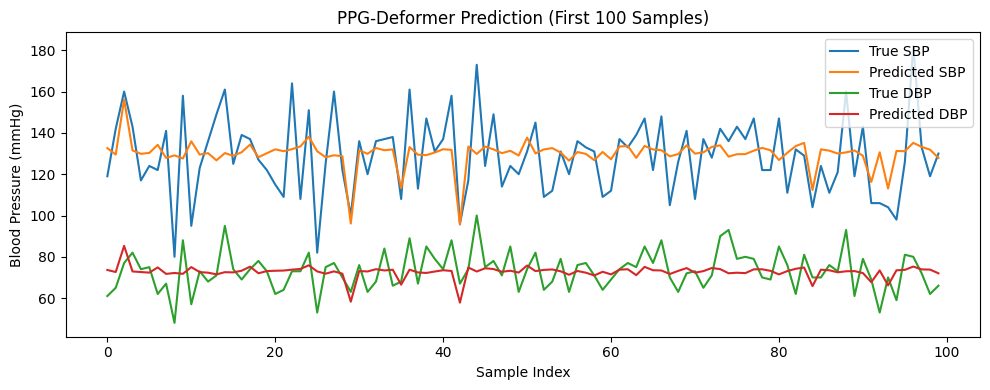

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

# 영어 기본 폰트로 리셋
plt.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['axes.unicode_minus'] = False  # 음수 부호 깨짐 방지


def evaluate_model(model, test_loader, device, plot_range=100):
    model.eval()
    preds_list, labels_list = [], []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().numpy()
            preds_list.append(preds)
            labels_list.append(yb.numpy())

    all_preds = np.vstack(preds_list)
    all_labels = np.vstack(labels_list)

    rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
    mae = mean_absolute_error(all_labels, all_preds)
    print(f"✅ Evaluation Result | RMSE: {rmse:.2f} | MAE: {mae:.2f}")

    # 결과 시각화
    plt.figure(figsize=(10, 4))
    plt.plot(all_labels[:plot_range, 0], label='True SBP')
    plt.plot(all_preds[:plot_range, 0], label='Predicted SBP')
    plt.plot(all_labels[:plot_range, 1], label='True DBP')
    plt.plot(all_preds[:plot_range, 1], label='Predicted DBP')
    plt.title(f"PPG-Deformer Prediction (First {plot_range} Samples)")
    plt.xlabel("Sample Index")
    plt.ylabel("Blood Pressure (mmHg)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return all_labels, all_preds

# 모델 평가
labels, preds = evaluate_model(model, test_loader, device)  # 필요시 활용




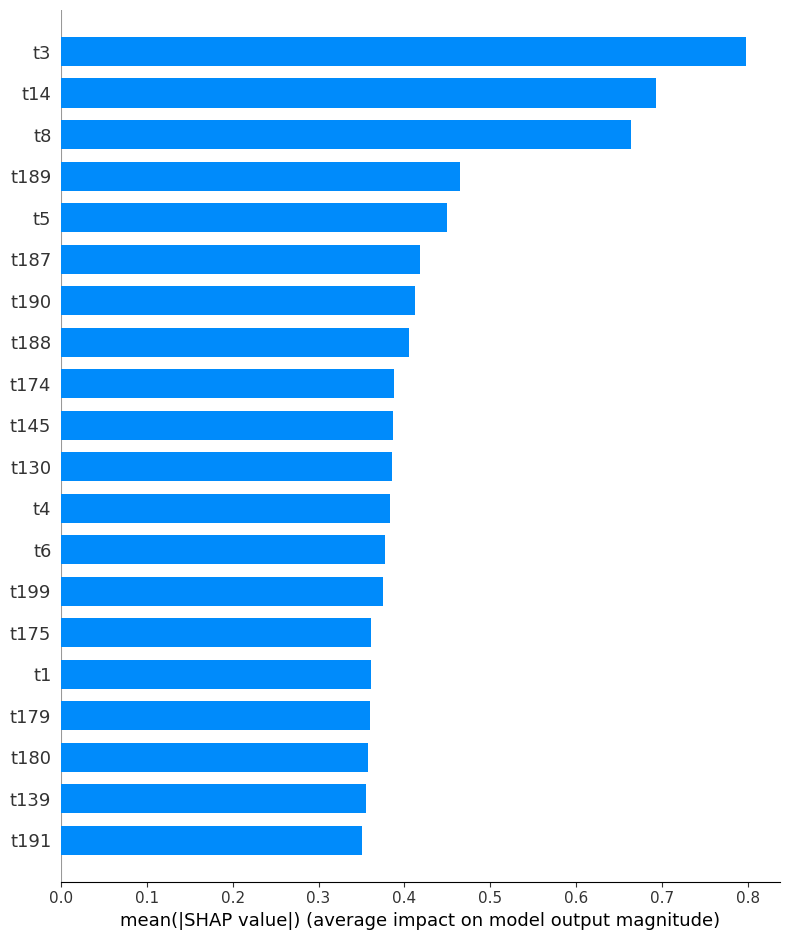

✅ SBP SHAP: (10, 200)
✅ DBP SHAP: (10, 200)
✅ X_np: (10, 200)


<ipython-input-45-be55eb52cd04>:34: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[0], X_np, feature_names=[f"t{i}" for i in range(200)], plot_type="bar")


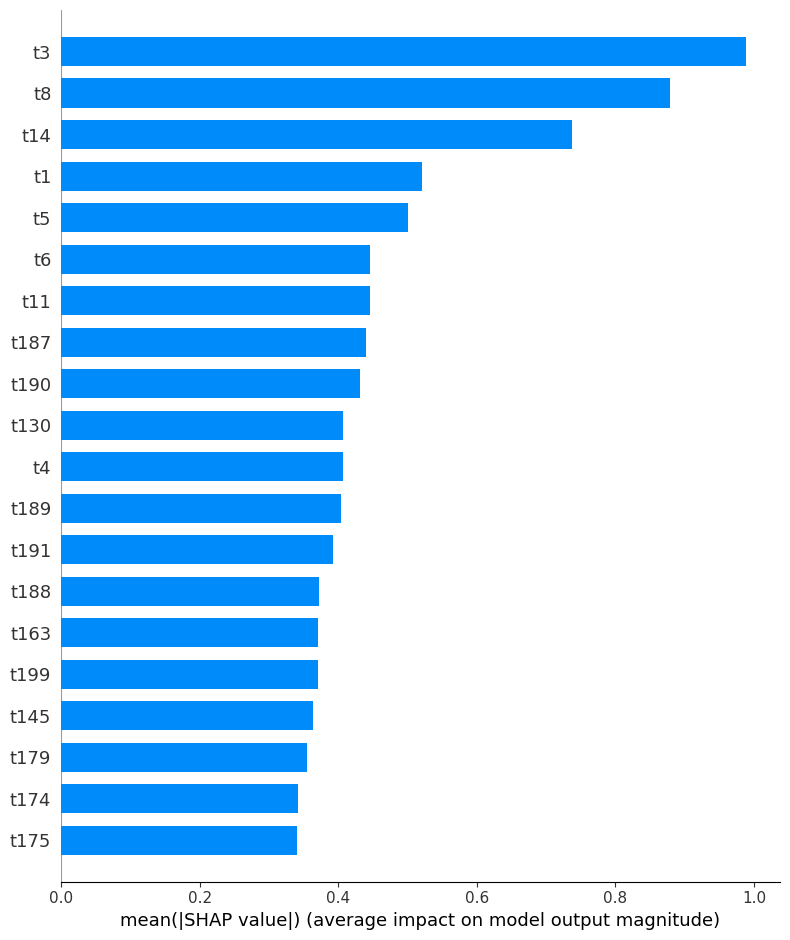

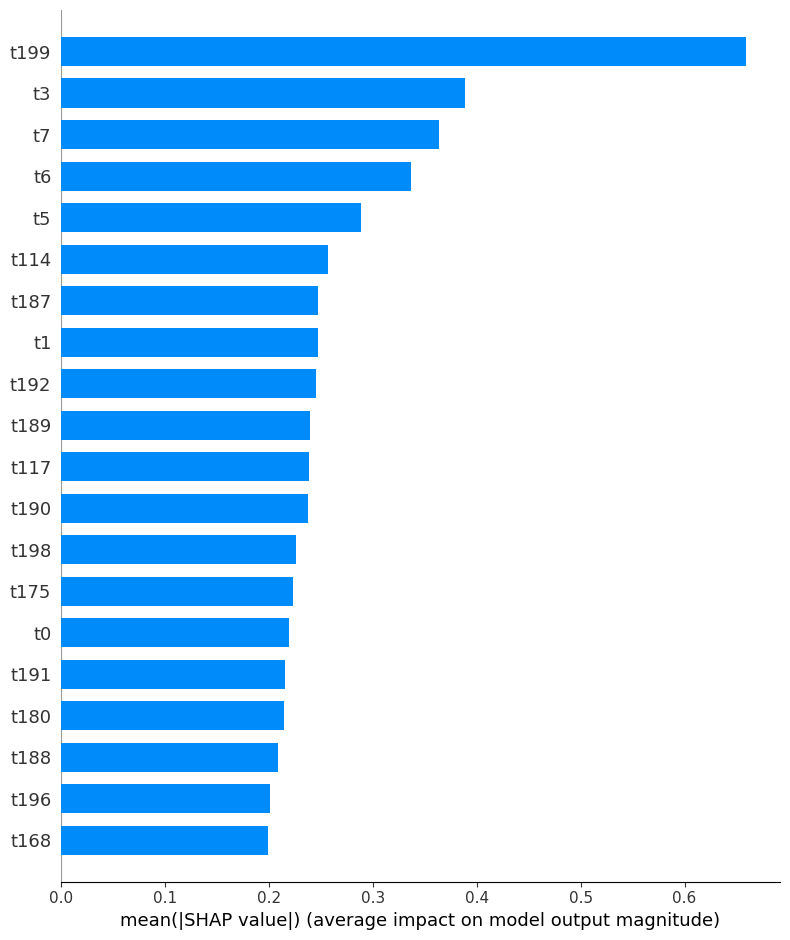

<ipython-input-45-be55eb52cd04>:47: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[1], X_np, feature_names=[f"t{i}" for i in range(200)], plot_type="bar")


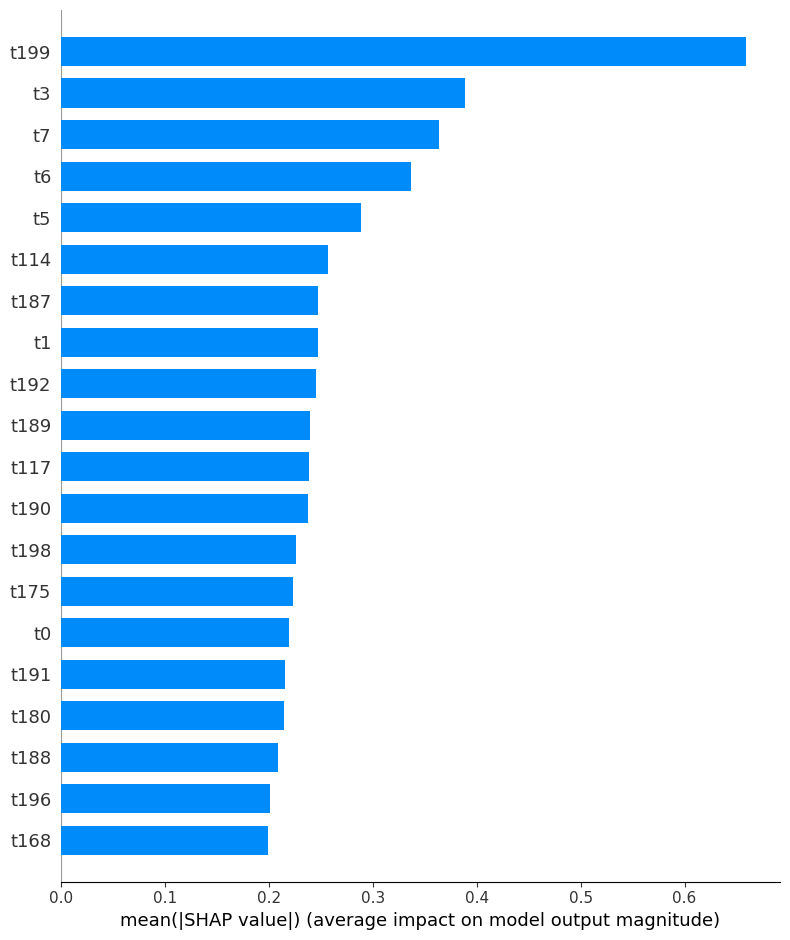

In [45]:
import numpy as np

# 명시적인 random number generator 생성
rng = np.random.default_rng(42)

# shap.summary_plot에 전달
shap.summary_plot(
    shap_values[0],
    X_np,
    feature_names=[f"t{i}" for i in range(200)],
    plot_type="bar",
    rng=rng   # 여기 추가!
)


# 1. 입력 준비
X_input = X_tensor[100:110].to(device)             # (10, 1, 200)
X_np = X_input.squeeze(1).cpu().numpy()            # (10, 200)

# 2. SHAP 실행
explainer = shap.GradientExplainer(model, X_tensor[:100].to(device))
shap_raw = explainer.shap_values(X_input)          # (10, 1, 200, 2)

# 3. 차원 정리
shap_raw = shap_raw.squeeze(1)                     # → (10, 200, 2)
shap_values = [shap_raw[:, :, 0], shap_raw[:, :, 1]]  # → (10, 200) each

# 4. 확인
print("✅ SBP SHAP:", shap_values[0].shape)
print("✅ DBP SHAP:", shap_values[1].shape)
print("✅ X_np:", X_np.shape)

# 5. 시각화
shap.summary_plot(shap_values[0], X_np, feature_names=[f"t{i}" for i in range(200)], plot_type="bar")

import numpy as np
rng = np.random.default_rng(42)  # 명시적 RNG 생성

shap.summary_plot(
    shap_values[1],               # DBP
    X_np,
    feature_names=[f"t{i}" for i in range(200)],
    plot_type="bar",
    rng=rng                       # 👉 경고 제거
)

shap.summary_plot(shap_values[1], X_np, feature_names=[f"t{i}" for i in range(200)], plot_type="bar")
